# Предсказание цен в Airbnb

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

np.random.seed(100)

## Загрузка данных

In [2]:
data = pd.read_csv("AB_NYC_2019.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

Датасет нуждается в очистке: если не считать удаляемые столбцы, много пустых значений в reviews_per_month

In [4]:
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


## EDA

Рекомендованные к удалению столбцы

In [5]:
to_drop = [
    'id',
    'name',
    'host_id',
    'host_name',
    'last_review'
]

In [6]:
data.drop(columns = to_drop, inplace = True)

In [7]:
data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


### Target variable: price

<AxesSubplot:>

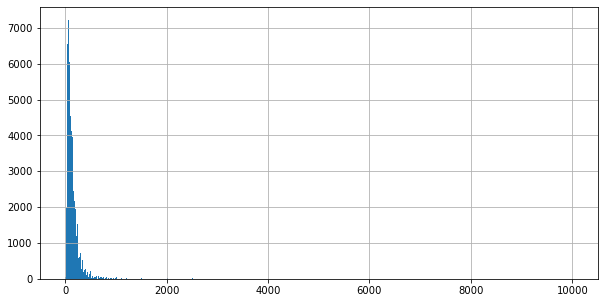

In [8]:
data['price'].hist(bins=500,figsize=[10,5])

Распределение целевой переменной нормальное, но с большим хвостом. Проверим объекты с очень высокой ценой

In [9]:
data[data['price'] > 5000]

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
3537,Manhattan,Upper West Side,40.77782,-73.97848,Entire home/apt,6000,14,17,0.27,1,359
3720,Manhattan,Little Italy,40.71895,-73.99793,Entire home/apt,5250,1,0,NaN,1,0
3774,Brooklyn,Clinton Hill,40.68766,-73.96439,Entire home/apt,6500,1,0,NaN,1,0
4377,Brooklyn,Clinton Hill,40.69137,-73.96723,Entire home/apt,8000,1,1,0.03,11,365
6530,Manhattan,East Harlem,40.79264,-73.93898,Entire home/apt,9999,5,1,0.02,1,0
9151,Queens,Astoria,40.76810,-73.91651,Private room,10000,100,2,0.04,1,0
12342,Manhattan,Lower East Side,40.71355,-73.98507,Private room,9999,99,6,0.14,1,83
15560,Manhattan,Greenwich Village,40.73046,-73.99562,Entire home/apt,6000,1,0,NaN,1,0
17692,Brooklyn,Greenpoint,40.73260,-73.95739,Entire home/apt,10000,5,5,0.16,1,0
29238,Manhattan,Upper West Side,40.77213,-73.98665,Entire home/apt,10000,30,0,NaN,1,83


Проверим объекты с нулевой ценой

In [10]:
data[data['price'] == 0]

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
23161,Brooklyn,Bedford-Stuyvesant,40.69023,-73.95428,Private room,0,4,1,0.05,4,28
25433,Bronx,East Morrisania,40.83296,-73.88668,Private room,0,2,55,2.56,4,127
25634,Brooklyn,Bushwick,40.69467,-73.92433,Private room,0,2,16,0.71,5,0
25753,Brooklyn,Greenpoint,40.72462,-73.94072,Private room,0,2,12,0.53,2,0
25778,Brooklyn,Williamsburg,40.70838,-73.94645,Entire home/apt,0,5,3,0.15,1,73
25794,Brooklyn,Bedford-Stuyvesant,40.68173,-73.91342,Private room,0,1,93,4.28,6,176
25795,Brooklyn,Bedford-Stuyvesant,40.68279,-73.91170,Private room,0,1,95,4.37,6,232
25796,Brooklyn,Bedford-Stuyvesant,40.68258,-73.91284,Private room,0,1,95,4.35,6,222
26259,Manhattan,Murray Hill,40.75091,-73.97597,Entire home/apt,0,3,0,NaN,1,0
26841,Brooklyn,Bushwick,40.69211,-73.90670,Shared room,0,30,2,0.11,6,333


Их не так много, можно избавиться

In [11]:
data = data[data['price'] > 0]

### neighbourhood_group

In [12]:
data['neighbourhood_group'].value_counts()

Manhattan        21660
Brooklyn         20095
Queens            5666
Bronx             1090
Staten Island      373
Name: neighbourhood_group, dtype: int64

5 районов, превратим этот столбец на следующем этапе в dummies

### neighbourhood

In [13]:
data['neighbourhood'].value_counts()

Williamsburg          3919
Bedford-Stuyvesant    3710
Harlem                2658
Bushwick              2462
Upper West Side       1971
                      ... 
Fort Wadsworth           1
Willowbrook              1
New Dorp                 1
Richmondtown             1
Woodrow                  1
Name: neighbourhood, Length: 221, dtype: int64

Много субрайонов, превращение в dummies вряд ли целесообразно

<AxesSubplot:>

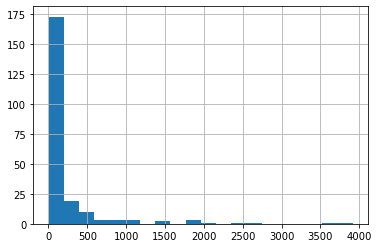

In [14]:
data['neighbourhood'].value_counts().hist(bins=20)

### room_type

In [15]:
data['room_type'].value_counts()

Entire home/apt    25407
Private room       22319
Shared room         1158
Name: room_type, dtype: int64

3 типа апартаментов, превратим этот столбец на следующем этапе в dummies

### minimum_nights

<AxesSubplot:>

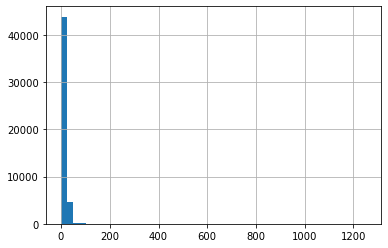

In [16]:
data['minimum_nights'].hist(bins=50)

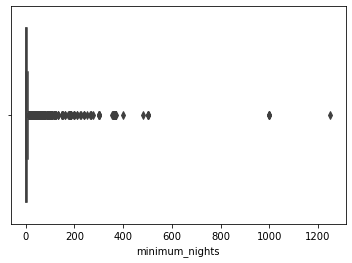

In [17]:
sns.boxplot(x=data['minimum_nights']);

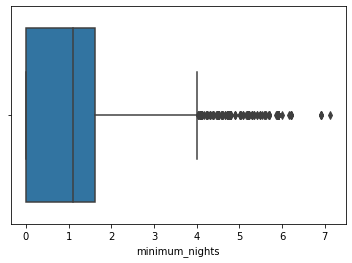

In [18]:
sns.boxplot(x=np.log(data['minimum_nights']));

Очень большой хвост, возможно, много выбросов. Возможно, перевод в логарифмическую шкалу улучшит качество предсказания

### number_of_reviews

<AxesSubplot:>

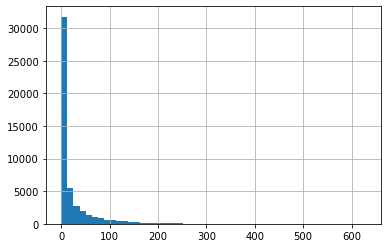

In [19]:
data['number_of_reviews'].hist(bins=50)

### reviews_per_month

Проверим, какие значения number_of_reviews в объектах с пустым reviews_per_month

In [20]:
data[pd.isnull(data['reviews_per_month'])]['number_of_reviews'].value_counts()

0    10051
Name: number_of_reviews, dtype: int64

Заменим пустые значения нулями

In [21]:
data['reviews_per_month'].fillna(0, inplace = True)

<AxesSubplot:>

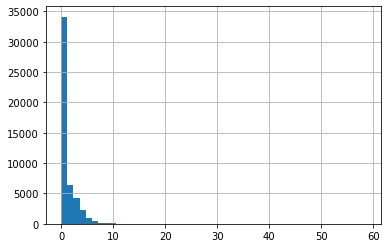

In [22]:
data['reviews_per_month'].hist(bins=50)

<AxesSubplot:>

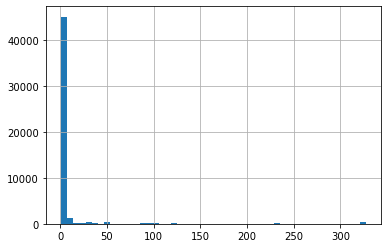

In [23]:
data['calculated_host_listings_count'].hist(bins=50)

### calculated_host_listings_count

<AxesSubplot:>

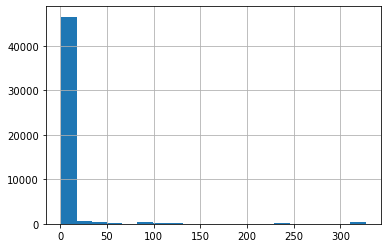

In [24]:
data['calculated_host_listings_count'].hist(bins=20)

<AxesSubplot:>

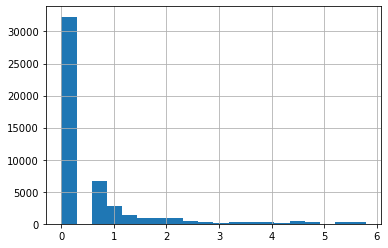

In [25]:
np.log(data['calculated_host_listings_count']).hist(bins=20)

Возможно, стоит перевести в логарифмическую шкалу

### availability_365

<AxesSubplot:>

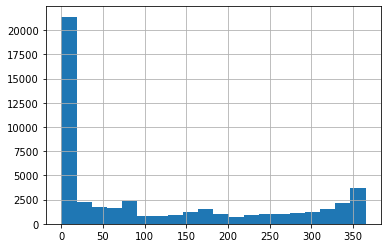

In [26]:
data['availability_365'].hist(bins=20)

In [27]:
data[data['availability_365'] == 0]

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0
6,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,49,0.40,1,0
8,Manhattan,Upper West Side,40.80178,-73.96723,Private room,79,2,118,0.99,1,0
14,Manhattan,West Village,40.73530,-74.00525,Entire home/apt,120,90,27,0.22,1,0
20,Brooklyn,Williamsburg,40.71842,-73.95718,Entire home/apt,299,3,9,0.07,1,0
...,...,...,...,...,...,...,...,...,...,...,...
48550,Queens,Ridgewood,40.69919,-73.89902,Private room,45,1,0,0.00,1,0
48731,Brooklyn,Park Slope,40.66716,-73.98101,Entire home/apt,111,8,0,0.00,1,0
48756,Manhattan,Murray Hill,40.74404,-73.97239,Entire home/apt,129,2,0,0.00,1,0
48760,Queens,Sunnyside,40.74719,-73.91919,Private room,46,1,0,0.00,1,0


С одной стороны, можно было бы удалить объекты с availability_365 == 0. С другой стороны, их довольно много

## Correlation map

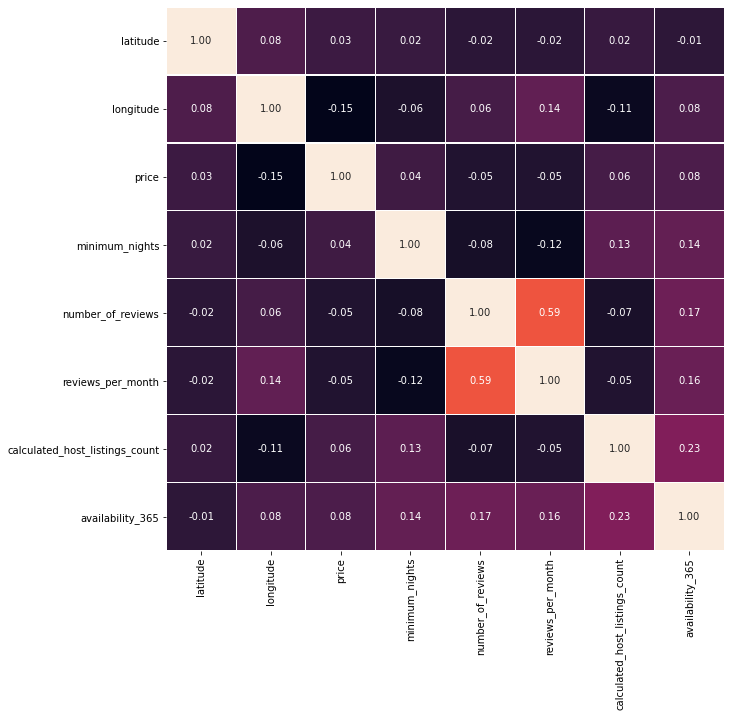

In [28]:
plt.figure(figsize=(10, 10))
sns.heatmap(data.corr(), annot=True, cbar=False, linewidths=.1, fmt= '.2f')
plt.show()

Корреляция видна между количеством отзывов и количеством отзывов в месяц, что естественно. Построим для них диаграмму рассеяния

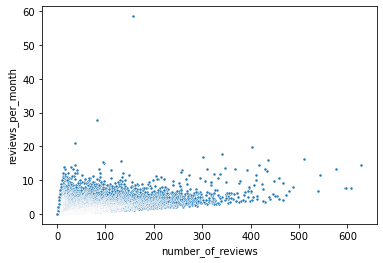

In [29]:
sns.scatterplot(data=data, x='number_of_reviews', y='reviews_per_month', marker=".");

## Preprocessing & Feature Engineering

Сделаем запланированные преобразования get_dummies, а для neighbourhood выполним частотное кодирование

In [30]:
data = pd.get_dummies(data, columns=['neighbourhood_group'], prefix='neighbourhood_group')

In [31]:
neighbourhood_frequency_map = data['neighbourhood'].value_counts(normalize=True)
data['neighbourhood_frequency'] = data['neighbourhood'].map(neighbourhood_frequency_map)

In [32]:
data = pd.get_dummies(data, columns=['room_type'], prefix='room_type')

In [33]:
data.drop(columns = ['neighbourhood'], inplace = True)
data

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,neighbourhood_frequency,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,40.64749,-73.97237,149,1,9,0.21,6,365,0,1,0,0,0,0.003580,0,1,0
1,40.75362,-73.98377,225,1,45,0.38,2,355,0,0,1,0,0,0.031605,1,0,0
2,40.80902,-73.94190,150,3,0,0.00,1,365,0,0,1,0,0,0.054374,0,1,0
3,40.68514,-73.95976,89,1,270,4.64,1,194,0,1,0,0,0,0.011701,1,0,0
4,40.79851,-73.94399,80,10,9,0.10,1,0,0,0,1,0,0,0.022850,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,40.67853,-73.94995,70,2,0,0.00,2,9,0,1,0,0,0,0.075894,0,1,0
48891,40.70184,-73.93317,40,4,0,0.00,2,36,0,1,0,0,0,0.050364,0,1,0
48892,40.81475,-73.94867,115,10,0,0.00,1,27,0,0,1,0,0,0.054374,1,0,0
48893,40.75751,-73.99112,55,1,0,0.00,6,2,0,0,1,0,0,0.040054,0,0,1


In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48884 entries, 0 to 48894
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   latitude                           48884 non-null  float64
 1   longitude                          48884 non-null  float64
 2   price                              48884 non-null  int64  
 3   minimum_nights                     48884 non-null  int64  
 4   number_of_reviews                  48884 non-null  int64  
 5   reviews_per_month                  48884 non-null  float64
 6   calculated_host_listings_count     48884 non-null  int64  
 7   availability_365                   48884 non-null  int64  
 8   neighbourhood_group_Bronx          48884 non-null  uint8  
 9   neighbourhood_group_Brooklyn       48884 non-null  uint8  
 10  neighbourhood_group_Manhattan      48884 non-null  uint8  
 11  neighbourhood_group_Queens         48884 non-null  uin

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['price'], axis=1), 
    data['price'], 
    test_size=0.3
)

In [36]:
X_train.shape, X_test.shape

((34218, 16), (14666, 16))

## Scaling

In [37]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [38]:
continuous_vars = [
    'latitude', 
    'longitude',
    'minimum_nights',
    'number_of_reviews',
    'reviews_per_month',
    'calculated_host_listings_count',
    'availability_365'
]

In [39]:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[continuous_vars] = scaler.fit_transform(X_train_scaled[continuous_vars])
X_test_scaled[continuous_vars] = scaler.transform(X_test_scaled[continuous_vars])

## Machine Learning

### Метрики

In [40]:
from sklearn import metrics

def dataframe_metrics(y_test,y_pred):
    stats = [
       metrics.mean_absolute_error(y_test, y_pred),
       np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
       metrics.r2_score(y_test, y_pred)
    ]
    return stats

measured_metrics = pd.DataFrame({"error_type":["MAE", "RMSE", "R2"]})
measured_metrics.set_index("error_type")

""
error_type
MAE
RMSE
R2


### Baseline

Вычислим метрики качества для медианных значений без всякой модели, чтобы потом сравнивать с метриками моделей

In [41]:
median_train = y_train.median()
y_test_baseline = np.array([median_train]*len(y_test))

In [42]:
measured_metrics["baseline"] = dataframe_metrics(y_test, y_test_baseline)
measured_metrics

,error_type,baseline
0,MAE,82.316514
1,RMSE,232.358943
2,R2,-0.034587


### Linear Regression

In [43]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

In [44]:
lin_reg = LinearRegression()

lin_reg.fit(X_train_scaled, y_train)

LinearRegression()

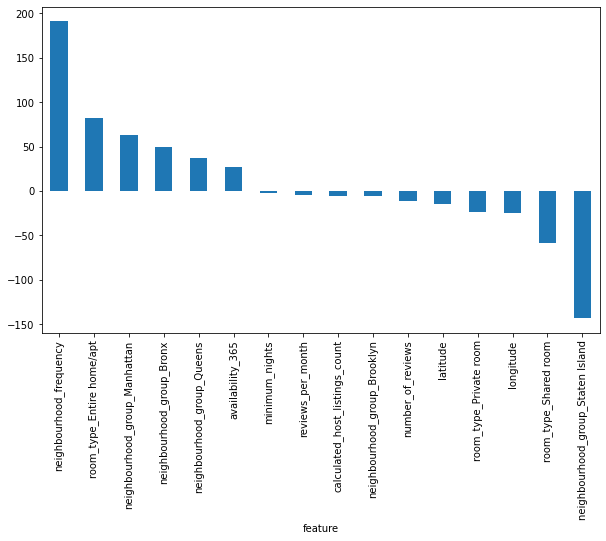

In [45]:
featureImportance = pd.DataFrame({"feature": X_train.columns, 
                                  "importance": lin_reg.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot.bar(figsize=(10, 6));

In [46]:
measured_metrics["lin_reg"] = dataframe_metrics(y_test, lin_reg.predict(X_test_scaled))
measured_metrics

,error_type,baseline,lin_reg
0,MAE,82.316514,72.813628
1,RMSE,232.358943,216.026911
2,R2,-0.034587,0.105740


Применили стандартную линейную регрессию. Метрики чуть лучше, чем у baseline. Больше всего на цену в положительную сторону влияет neighbourhood_frequency, а в отрицательную сторону — расположение в районе Staten Island.

### RidgeCV

In [47]:
ridge_cv = RidgeCV()

ridge_cv.fit(X_train_scaled, y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]))

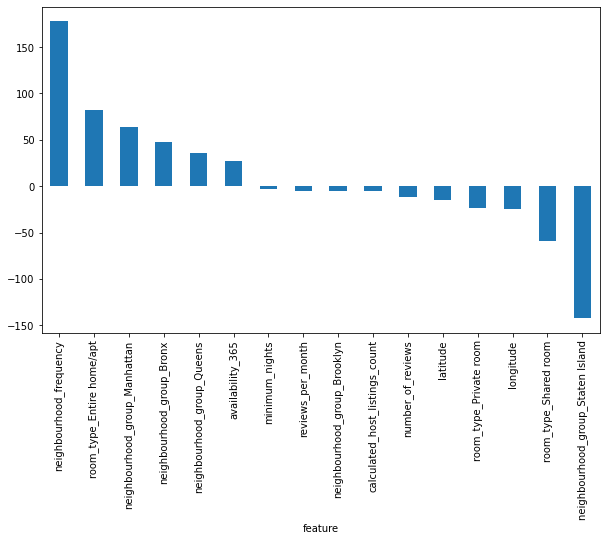

In [48]:
featureImportance = pd.DataFrame({"feature": X_train.columns, 
                                  "importance": ridge_cv.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot.bar(figsize=(10, 6));

In [49]:
measured_metrics["ridge_cv"] = dataframe_metrics(y_test, ridge_cv.predict(X_test_scaled))
measured_metrics

,error_type,baseline,lin_reg,ridge_cv
0,MAE,82.316514,72.813628,72.812922
1,RMSE,232.358943,216.026911,216.023149
2,R2,-0.034587,0.105740,0.105771


Применили ridge-регрессию. Метрики и влияние фич аналогичны стандартной линейной.

### LassoCV

In [50]:
lasso_cv = LassoCV()

lasso_cv.fit(X_train_scaled, y_train)

LassoCV()

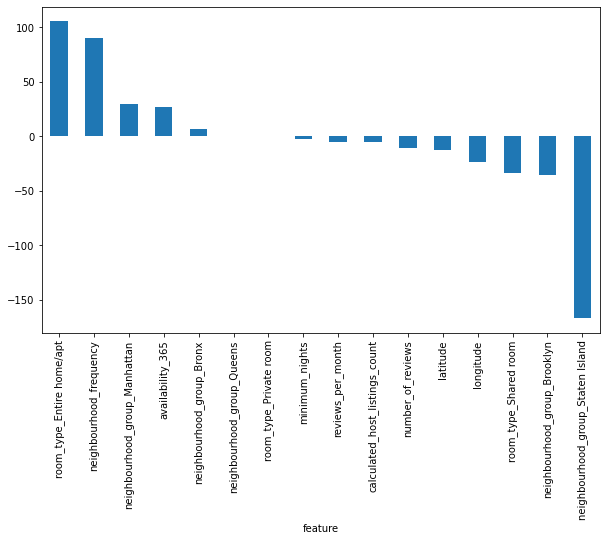

In [51]:
featureImportance = pd.DataFrame({"feature": X_train.columns, 
                                  "importance": lasso_cv.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot.bar(figsize=(10, 6));

In [52]:
measured_metrics["lasso_cv"] = dataframe_metrics(y_test, lasso_cv.predict(X_test_scaled))
measured_metrics

,error_type,baseline,lin_reg,ridge_cv,lasso_cv
0,MAE,82.316514,72.813628,72.812922,72.798458
1,RMSE,232.358943,216.026911,216.023149,216.002896
2,R2,-0.034587,0.105740,0.105771,0.105939


Применили lasso-регрессию. Метрики аналогичны предыдущим. На цену в положительную сторону больше всего влияют тип апартаментов целый дом и neighbourhood_frequency, в отрицательную — расположение в районе Staten Island.

### ElasticNet

In [53]:
elastic_net = ElasticNetCV()

elastic_net.fit(X_train_scaled, y_train)

ElasticNetCV()

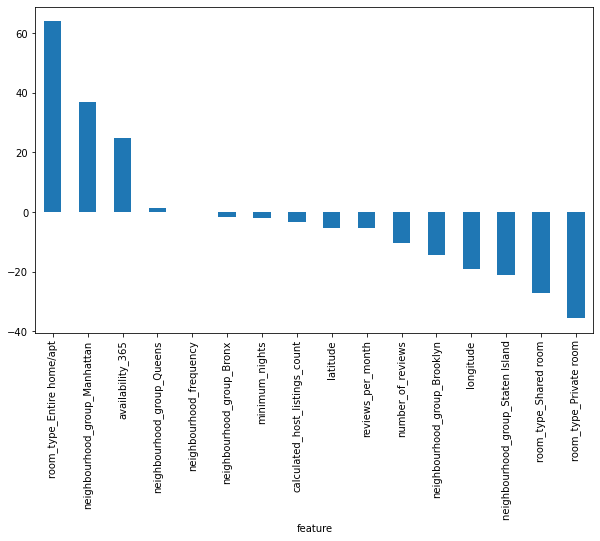

In [54]:
featureImportance = pd.DataFrame({"feature": X_train.columns, 
                                  "importance": elastic_net.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot.bar(figsize=(10, 6));

In [55]:
measured_metrics["elastic_net"] = dataframe_metrics(y_test, elastic_net.predict(X_test_scaled))
measured_metrics

,error_type,baseline,lin_reg,ridge_cv,lasso_cv,elastic_net
0,MAE,82.316514,72.813628,72.812922,72.798458,72.528201
1,RMSE,232.358943,216.026911,216.023149,216.002896,216.214978
2,R2,-0.034587,0.105740,0.105771,0.105939,0.104182


Применили эластичную сеть. Метрики аналогичны предыдущим, однако влияние фич кажется более оправданным. На цену в положительную сторону больше всего влияют тип апартаментов целый дом, расположение на Манхэттене и доступность по календарю, в отрицательную — тип апартаментов комнаты и расположение в районе Staten Island.

Для оценки преобразований будем пользоваться эластичной сетью.

## Преобразования

### Гипотеза № 1

**Гипотеза**: если перевести широту и долготу в расстояние до самого престижного места, модель будет работать лучше.

Создадим новый столбец length_to_esb (расстояние до Эмпайр-Стейт-Билдинг)

In [56]:
datav2 = data.copy()

In [57]:
esb_latitude = 40.748433
esb_longitude = -73.985656

datav2['length_to_esb'] = np.sqrt((esb_latitude - datav2['latitude']) ** 2 + (esb_longitude - datav2['longitude']) ** 2)
datav2['length_to_esb']

0        0.101814
1        0.005519
2        0.074735
3        0.068386
4        0.065144
           ...   
48890    0.078494
48891    0.070183
48892    0.075934
48893    0.010595
48894    0.016034
Name: length_to_esb, Length: 48884, dtype: float64

<AxesSubplot:>

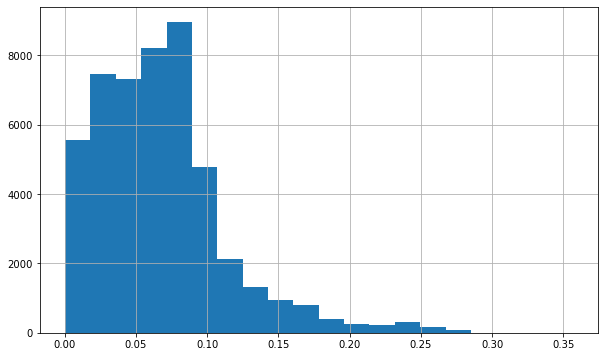

In [58]:
datav2['length_to_esb'].hist(bins=20, figsize=(10,6))

Удалим широту и долготу

In [59]:
to_drop = [
    'latitude',
    'longitude'
]

datav2.drop(columns = to_drop, inplace = True)

Сделаем новое разделение на train-test, масштабирование, обучение эластичной сети

In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    datav2.drop(['price'], axis=1), 
    datav2['price'], 
    test_size=0.3
)

In [61]:
continuous_vars = [
    'length_to_esb',
    'minimum_nights',
    'number_of_reviews',
    'reviews_per_month',
    'calculated_host_listings_count',
    'availability_365'
]

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[continuous_vars] = scaler.fit_transform(X_train_scaled[continuous_vars])
X_test_scaled[continuous_vars] = scaler.transform(X_test_scaled[continuous_vars])

In [62]:
elastic_net.fit(X_train_scaled, y_train)

ElasticNetCV()

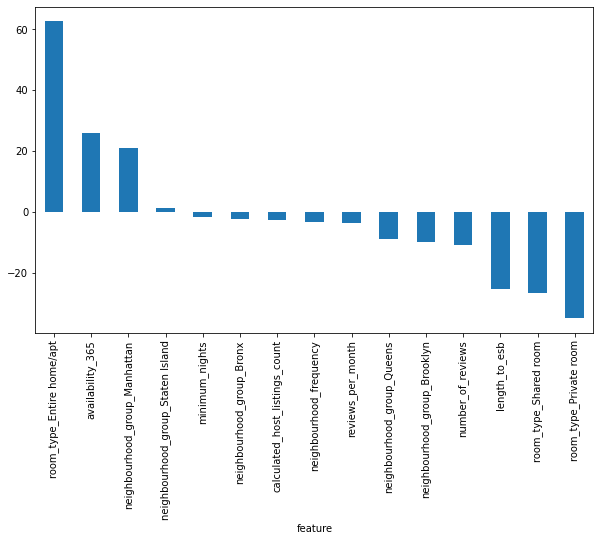

In [63]:
featureImportance = pd.DataFrame({"feature": X_train.columns, 
                                  "importance": elastic_net.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot.bar(figsize=(10, 6));

In [64]:
measured_metrics["elastic_net_v2"] = dataframe_metrics(y_test, elastic_net.predict(X_test_scaled))
measured_metrics

,error_type,baseline,lin_reg,ridge_cv,lasso_cv,elastic_net,elastic_net_v2
0,MAE,82.316514,72.813628,72.812922,72.798458,72.528201,73.182896
1,RMSE,232.358943,216.026911,216.023149,216.002896,216.214978,237.833511
2,R2,-0.034587,0.105740,0.105771,0.105939,0.104182,0.093072


**Вывод**: Новый столбец length_to_esb вошёл в число фич, отрицательно влияющих на цену. Однако метрики качества стали ниже.

### Гипотеза № 2

**Гипотеза**: Модель будет работать лучше, если для столбца neighbourhood вместо частотного кодирования сделать one-hot encoding.

Загрузим оригинальные данные, удалим объекты с нулевой ценой, после чего скопируем из них оригинальный столбец neighbourhood и применим get_dummies.

In [66]:
data_original = pd.read_csv("AB_NYC_2019.csv")
data_original = data_original[data_original['price'] > 0]
datav3 = data.copy()

In [67]:
datav3['neighbourhood'] = data_original['neighbourhood']

datav3.drop(columns = 'neighbourhood_frequency', inplace = True)

In [68]:
datav3 = pd.get_dummies(datav3, columns=['neighbourhood'], prefix='neighbourhood')
datav3

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,...,neighbourhood_Westerleigh,neighbourhood_Whitestone,neighbourhood_Williamsbridge,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside
0,40.64749,-73.97237,149,1,9,0.21,6,365,0,1,...,0,0,0,0,0,0,0,0,0,0
1,40.75362,-73.98377,225,1,45,0.38,2,355,0,0,...,0,0,0,0,0,0,0,0,0,0
2,40.80902,-73.94190,150,3,0,0.00,1,365,0,0,...,0,0,0,0,0,0,0,0,0,0
3,40.68514,-73.95976,89,1,270,4.64,1,194,0,1,...,0,0,0,0,0,0,0,0,0,0
4,40.79851,-73.94399,80,10,9,0.10,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,40.67853,-73.94995,70,2,0,0.00,2,9,0,1,...,0,0,0,0,0,0,0,0,0,0
48891,40.70184,-73.93317,40,4,0,0.00,2,36,0,1,...,0,0,0,0,0,0,0,0,0,0
48892,40.81475,-73.94867,115,10,0,0.00,1,27,0,0,...,0,0,0,0,0,0,0,0,0,0
48893,40.75751,-73.99112,55,1,0,0.00,6,2,0,0,...,0,0,0,0,0,0,0,0,0,0


Сделаем новое разделение на train-test, масштабирование, обучение эластичной сети

In [69]:
X_train, X_test, y_train, y_test = train_test_split(
    datav3.drop(['price'], axis=1), 
    datav3['price'], 
    test_size=0.3
)

In [70]:
continuous_vars = [
    'latitude',
    'longitude',
    'minimum_nights',
    'number_of_reviews',
    'reviews_per_month',
    'calculated_host_listings_count',
    'availability_365'
]

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[continuous_vars] = scaler.fit_transform(X_train_scaled[continuous_vars])
X_test_scaled[continuous_vars] = scaler.transform(X_test_scaled[continuous_vars])

In [71]:
elastic_net.fit(X_train_scaled, y_train)

ElasticNetCV()

In [72]:
measured_metrics["elastic_net_v3"] = dataframe_metrics(y_test, elastic_net.predict(X_test_scaled))
measured_metrics

,error_type,baseline,lin_reg,ridge_cv,lasso_cv,elastic_net,elastic_net_v2,elastic_net_v3
0,MAE,82.316514,72.813628,72.812922,72.798458,72.528201,73.182896,73.079582
1,RMSE,232.358943,216.026911,216.023149,216.002896,216.214978,237.833511,251.347929
2,R2,-0.034587,0.105740,0.105771,0.105939,0.104182,0.093072,0.083505


**Вывод**: Гипотеза не оправдалась, метрики стали хуже. График важности фич не строили из-за большого их количества.

### Гипотеза № 3

**Гипотеза**: Преобразуем столбец minimum_nights к логарифмической шкале и удалим строки с выбросами.

In [73]:
datav4 = data.copy()

In [74]:
datav4['log_minimum_nights'] = np.log(datav4['minimum_nights'])

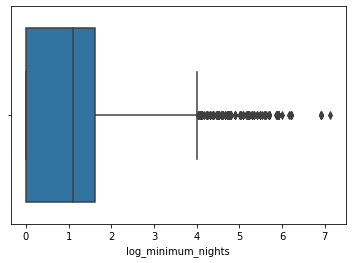

In [75]:
sns.boxplot(x=datav4['log_minimum_nights']);

In [76]:
datav4.drop(columns = 'minimum_nights', inplace = True)
datav4.shape

(48884, 17)

In [77]:
datav4 = datav4[datav4['log_minimum_nights'] <= 4]
datav4.shape

(48433, 17)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(
    datav4.drop(['price'], axis=1), 
    datav4['price'], 
    test_size=0.3
)

In [79]:
continuous_vars = [
    'latitude',
    'longitude',
    'log_minimum_nights',
    'number_of_reviews',
    'reviews_per_month',
    'calculated_host_listings_count',
    'availability_365'
]

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[continuous_vars] = scaler.fit_transform(X_train_scaled[continuous_vars])
X_test_scaled[continuous_vars] = scaler.transform(X_test_scaled[continuous_vars])

In [80]:
elastic_net.fit(X_train_scaled, y_train)

ElasticNetCV()

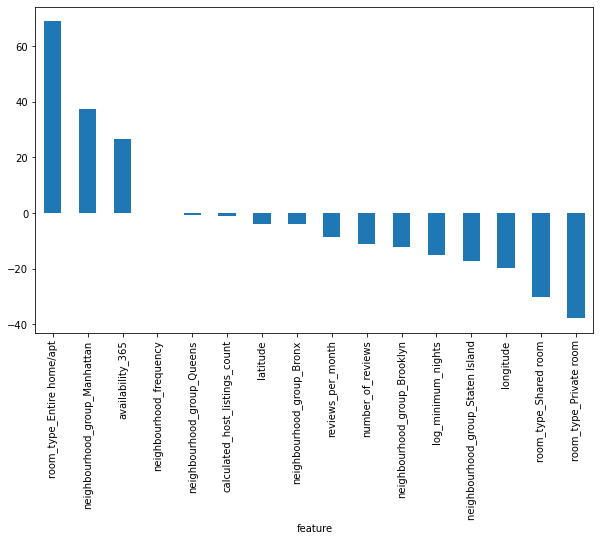

In [82]:
featureImportance = pd.DataFrame({"feature": X_train.columns, 
                                  "importance": elastic_net.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot.bar(figsize=(10, 6));

In [81]:
measured_metrics["elastic_net_v4"] = dataframe_metrics(y_test, elastic_net.predict(X_test_scaled))
measured_metrics

,error_type,baseline,lin_reg,ridge_cv,lasso_cv,elastic_net,elastic_net_v2,elastic_net_v3,elastic_net_v4
0,MAE,82.316514,72.813628,72.812922,72.798458,72.528201,73.182896,73.079582,69.216220
1,RMSE,232.358943,216.026911,216.023149,216.002896,216.214978,237.833511,251.347929,168.316800
2,R2,-0.034587,0.105740,0.105771,0.105939,0.104182,0.093072,0.083505,0.154623


**Вывод**: Сработало, метрики стали лучше.

### Гипотеза № 4

А что если вместо стандартного использовать RobustScaler?

In [84]:
from sklearn.preprocessing import RobustScaler
robust_scaler = RobustScaler()

In [85]:
continuous_vars = [
    'latitude',
    'longitude',
    'log_minimum_nights',
    'number_of_reviews',
    'reviews_per_month',
    'calculated_host_listings_count',
    'availability_365'
]

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[continuous_vars] = robust_scaler.fit_transform(X_train_scaled[continuous_vars])
X_test_scaled[continuous_vars] = robust_scaler.transform(X_test_scaled[continuous_vars])

In [86]:
elastic_net.fit(X_train_scaled, y_train)

ElasticNetCV()

In [87]:
measured_metrics["elastic_net_v4_robust"] = dataframe_metrics(y_test, elastic_net.predict(X_test_scaled))
measured_metrics

,error_type,baseline,lin_reg,ridge_cv,lasso_cv,elastic_net,elastic_net_v2,elastic_net_v3,elastic_net_v4,elastic_net_v4_robust
0,MAE,82.316514,72.813628,72.812922,72.798458,72.528201,73.182896,73.079582,69.216220,71.925084
1,RMSE,232.358943,216.026911,216.023149,216.002896,216.214978,237.833511,251.347929,168.316800,171.848782
2,R2,-0.034587,0.105740,0.105771,0.105939,0.104182,0.093072,0.083505,0.154623,0.118771


**Вывод**: Стандартный scaler справился лучше.